In [1]:
import pandas as pd
import time
import numpy as np
import requests
import io
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics.cluster import adjusted_rand_score
%matplotlib inline

In [2]:
url = 'https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2013/results.csv'

data_file = requests.get(url).content
df = pd.read_csv(io.StringIO(data_file.decode('ISO-8859-1')))
pd.options.mode.chained_assignment = None

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16164 entries, 0 to 16163
Data columns (total 21 columns):
25k          16164 non-null object
age          16164 non-null int64
name         16164 non-null object
division     16164 non-null int64
10k          16164 non-null object
gender       16164 non-null object
half         16164 non-null object
official     16164 non-null float64
bib          16164 non-null object
ctz          757 non-null object
country      16164 non-null object
overall      16164 non-null int64
pace         16164 non-null float64
state        14701 non-null object
30k          16164 non-null object
5k           16164 non-null object
genderdiv    16164 non-null int64
20k          16164 non-null object
35k          16164 non-null object
city         16163 non-null object
40k          16164 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 2.6+ MB


In [4]:
df = df[~df.bib.str.contains('W')]
df = df[~df.bib.str.contains('F')]

In [5]:
df['bib'] = df['bib'].astype(int)

In [6]:
#NOTE: after working with 'bib' and attempting to turn into a categorical variable, decided to drop it
df = df.drop(['bib'], axis=1)

In [7]:
df.head()

,25k,age,name,division,10k,gender,half,official,ctz,country,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,NaN,KEN,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,NaN,ETH,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
5,77.25,28,"Gebremariam, Gebregziabher",3,30.88,M,64.92,130.47,NaN,ETH,3,4.98,NaN,92.72,15.93,3,61.53,108.70,Tigray,123.78
7,77.23,28,"Geneti, Markos",6,30.88,M,64.90,132.73,NaN,ETH,6,5.07,NaN,92.93,15.90,6,61.52,109.07,Addis Ababa,125.20
9,77.25,32,"Merga, Deriba",25,30.90,M,64.92,141.67,NaN,ETH,27,5.42,NaN,92.77,15.93,27,61.53,111.13,Addis Ababa,131.98


In [8]:
df = df.drop(['name'], axis=1)

In [9]:
total_missing = df.isnull().sum().sort_values(ascending=False)
percent_missing = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
ctz,15359,0.953324
state,1447,0.089814
city,1,0.000062
40k,0,0.000000
age,0,0.000000
division,0,0.000000
10k,0,0.000000
gender,0,0.000000
half,0,0.000000
official,0,0.000000


In [10]:
print(df['division'].isnull().values.any())
print(df['genderdiv'].isnull().values.any())

False
False


In [11]:
#determine how often "division" and "genderdiv" are different
df['div_equal'] = np.where((df.division!=df.genderdiv),0,1)
df.div_equal.value_counts()

0    16090
1       21
Name: div_equal, dtype: int64

In [12]:
#drop division and keep genderdiv, since neither have blank values and on 21 differ
#frop ctz column because it is 95% Nan
df = df.drop(['division', 'ctz', 'div_equal'], axis=1)

In [13]:
#NOTE: after evaluation, decided to drop BOTH division data points, as these were not providing meaningful data
df = df.drop(['genderdiv'], axis=1)

In [14]:
df.head()

,25k,age,10k,gender,half,official,country,overall,pace,state,30k,5k,20k,35k,city,40k
1,77.27,30,30.90,M,64.90,132.50,KEN,5,5.07,NaN,92.97,15.90,61.52,108.78,Kenya,124.77
2,77.23,23,30.90,M,64.92,130.37,ETH,1,4.98,NaN,92.72,15.93,61.53,108.68,Ambo,123.78
5,77.25,28,30.88,M,64.92,130.47,ETH,3,4.98,NaN,92.72,15.93,61.53,108.70,Tigray,123.78
7,77.23,28,30.88,M,64.90,132.73,ETH,6,5.07,NaN,92.93,15.90,61.52,109.07,Addis Ababa,125.20
9,77.25,32,30.90,M,64.92,141.67,ETH,27,5.42,NaN,92.77,15.93,61.53,111.13,Addis Ababa,131.98


In [15]:
non_num = df.select_dtypes(['object']).columns

In [16]:
#check for symbols that keep us from turning columns from object to float
for col in non_num:
    count = df.loc[df[col]== '-'].count()
    print('Count "-" = {} {}'.format(col, count[col]))

Count "-" = 25k 23
Count "-" = 10k 26
Count "-" = gender 0
Count "-" = half 16
Count "-" = country 0
Count "-" = state 0
Count "-" = 30k 17
Count "-" = 5k 66
Count "-" = 20k 17
Count "-" = 35k 21
Count "-" = city 0
Count "-" = 40k 17


In [17]:
non_num = non_num.drop(['gender', 'country', 'state', 'city'])

In [18]:
for col in non_num:
    df = df[~df[col].str.contains('-', na=False)]
    df[col] = df[col].astype(float)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16001 entries, 1 to 16163
Data columns (total 16 columns):
25k         16001 non-null float64
age         16001 non-null int64
10k         16001 non-null float64
gender      16001 non-null object
half        16001 non-null float64
official    16001 non-null float64
country     16001 non-null object
overall     16001 non-null int64
pace        16001 non-null float64
state       14572 non-null object
30k         16001 non-null float64
5k          16001 non-null float64
20k         16001 non-null float64
35k         16001 non-null float64
city        16000 non-null object
40k         16001 non-null float64
dtypes: float64(10), int64(2), object(4)
memory usage: 2.1+ MB


In [20]:
df[['state', 'official']].groupby(['state'], as_index=False).mean().sort_values(by='official', ascending=False)

,state,official
52,SC,216.457634
1,AE,216.392500
38,NL,216.381000
54,SK,215.530000
24,MB,215.227500
...,...,...
48,PE,202.360000
39,NM,201.921579
11,DC,201.263793
31,MT,199.496897


In [21]:
df[['age', 'official']].groupby(['age'], as_index=False).mean().sort_values(by='official', ascending=False)

,age,official
59,78,243.780000
56,74,240.570000
57,75,237.500000
58,76,237.050000
52,70,235.096364
...,...,...
15,33,196.658613
7,25,196.511336
8,26,195.849006
2,20,195.640408


In [22]:
#drop city before one hot encoding because there are 4,284 unique values
df = df.drop(['city'], axis=1)

In [23]:
non_num = df.select_dtypes(['object']).columns

for col in non_num:
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col, drop_first=True)], axis=1)
    dummy_column_names = list(pd.get_dummies(df[col], prefix=col, drop_first=True).columns)
    df = df.drop([col], axis=1)

In [24]:
df.describe()

,25k,age,10k,half,official,overall,pace,30k,5k,20k,...,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,state_YT
count,16001.000000,16001.000000,16001.000000,16001.000000,16001.000000,16001.000000,16001.000000,16001.000000,16001.000000,16001.000000,...,16001.000000,16001.000000,16001.000000,16001.000000,16001.000000,16001.000000,16001.000000,16001.000000,16001.000000,16001.000000
mean,118.397314,41.661896,46.814358,99.396811,208.470547,8458.038248,7.959267,143.802023,23.463525,94.209808,...,0.011062,0.040872,0.015124,0.028436,0.004187,0.024373,0.021874,0.002250,0.001187,0.000125
std,12.275293,10.352068,4.731852,10.175273,23.124373,5037.526738,0.882091,15.224424,2.367896,9.636653,...,0.104595,0.198001,0.122050,0.166219,0.064575,0.154211,0.146275,0.047381,0.034440,0.011180
min,77.150000,18.000000,30.880000,64.900000,130.370000,1.000000,4.980000,92.700000,15.570000,61.520000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,109.050000,34.000000,43.270000,91.670000,191.900000,4102.000000,7.330000,132.320000,21.750000,86.900000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,119.270000,42.000000,47.220000,100.170000,209.370000,8281.000000,8.000000,144.820000,23.650000,94.930000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,127.370000,49.000000,50.300000,106.880000,225.280000,12676.000000,8.600000,154.870000,25.200000,101.320000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,163.620000,80.000000,66.680000,138.670000,284.230000,17598.000000,10.850000,195.870000,33.220000,131.720000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
df.corr()

,25k,age,10k,half,official,overall,pace,30k,5k,20k,...,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,state_YT
25k,1.000000,0.384840,0.978482,0.996323,0.938435,0.926818,0.938391,0.994202,0.961926,0.995376,...,0.015973,0.012116,0.035425,0.006554,-0.004877,0.019455,0.025454,0.000018,0.003461,0.003942
age,0.384840,1.000000,0.377736,0.385932,0.372321,0.369538,0.372331,0.382470,0.371478,0.385406,...,0.006744,0.002291,-0.009853,0.000321,0.000529,0.020940,-0.016331,-0.010299,-0.001503,0.002525
10k,0.978482,0.377736,1.000000,0.988464,0.885244,0.874000,0.885193,0.959905,0.992712,0.989749,...,0.019764,0.014687,0.032255,0.009148,-0.005415,0.020936,0.025311,-0.000916,0.001452,0.002069
half,0.996323,0.385932,0.988464,1.000000,0.920199,0.909183,0.920155,0.984928,0.973392,0.999691,...,0.017849,0.012551,0.034609,0.006770,-0.004591,0.020835,0.024653,0.000227,0.003278,0.003630
official,0.938435,0.372321,0.885244,0.920199,1.000000,0.984305,0.999980,0.962393,0.865709,0.917205,...,0.006061,0.013446,0.036175,0.005698,-0.009196,0.011091,0.022544,-0.000214,0.002901,0.001491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
state_WA,0.019455,0.020940,0.020936,0.020835,0.011091,0.013210,0.011113,0.017384,0.022390,0.021028,...,-0.016717,-0.032628,-0.019587,-0.027040,-0.010249,1.000000,-0.023636,-0.007506,-0.005450,-0.001767
state_WI,0.025454,-0.016331,0.025311,0.024653,0.022544,0.022933,0.022610,0.024645,0.025193,0.024440,...,-0.015816,-0.030870,-0.018531,-0.025583,-0.009697,-0.023636,1.000000,-0.007101,-0.005156,-0.001672
state_WV,0.000018,-0.010299,-0.000916,0.000227,-0.000214,0.000472,-0.000319,-0.000340,-0.000856,-0.000073,...,-0.005022,-0.009803,-0.005885,-0.008124,-0.003079,-0.007506,-0.007101,1.000000,-0.001637,-0.000531
state_WY,0.003461,-0.001503,0.001452,0.003278,0.002901,0.002530,0.002991,0.003841,0.001987,0.002961,...,-0.003647,-0.007118,-0.004273,-0.005899,-0.002236,-0.005450,-0.005156,-0.001637,1.000000,-0.000386


In [26]:
#decided to remove all check points except for '10K'
#this represents approx 25% of the race, so is the pace here representative of finish time?

#df = df.drop(['25k', 'half', '30k', '5k', '20k'], axis=1)

## K-means Clustering

In [29]:
#X = df.drop(['official'], axis=1)
#y = df['official']

X = df
X = normalize(X)

#X_pca = PCA(2).fit_transform(X)
#X = MinMaxScaler().fit_transform(X)

#X = StandardScaler().fit_transform(X)

In [32]:
start_time = time.time()

print('working...')

sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)
    
print("--- %s seconds ---" % round(time.time() - start_time, 2))

working...
--- 18.79 seconds ---


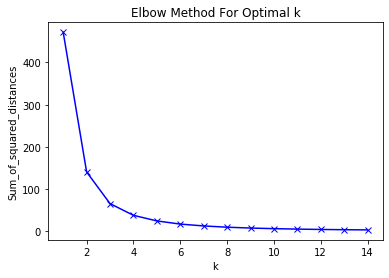

In [33]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [34]:
start_time = time.time()

print('working...')

y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X)

print("--- %s seconds ---" % round(time.time() - start_time, 2))

working...
--- 0.67 seconds ---


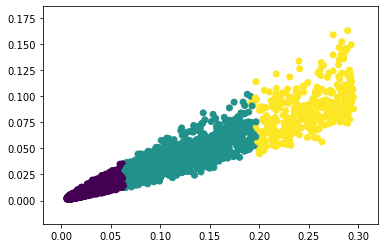

In [35]:
# Plot the solution.
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.show()

## Mean-Shift

In [36]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from mpl_toolkits.mplot3d import Axes3D

In [39]:
start_time = time.time()

print('working...')
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

cluster_centers = ms.cluster_centers_
labels = ms.labels_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("--- %s seconds ---" % round(time.time() - start_time, 2))
print("number of estimated clusters : %d" % n_clusters_)

#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels,
#                                           average_method='arithmetic'))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))



working...
--- 7.14 seconds ---
number of estimated clusters : 7


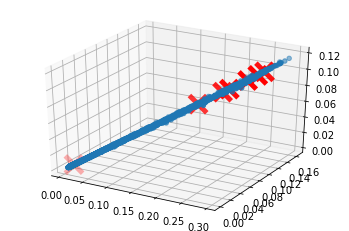

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], marker='o')
ax.scatter(cluster_centers[:,0], cluster_centers[:,1], cluster_centers[:,2], 
           marker='x', color='red', s=300, linewidth=5, zorder=10)
plt.show()

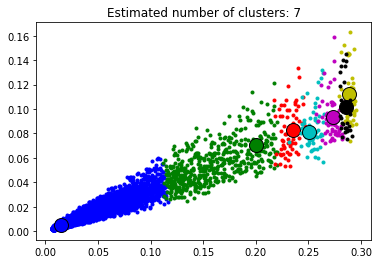

In [41]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

## Spectral Clustering

In [42]:
from sklearn.cluster import SpectralClustering
from scipy.spatial.distance import pdist, squareform

In [43]:
start_time = time.time()

print('working...')

clustering = SpectralClustering(n_clusters=3, assign_labels="discretize", random_state=0).fit(X)
y_pred = clustering.labels_

print("--- %s seconds ---" % round(time.time() - start_time, 2))


working...
--- 43.97 seconds ---


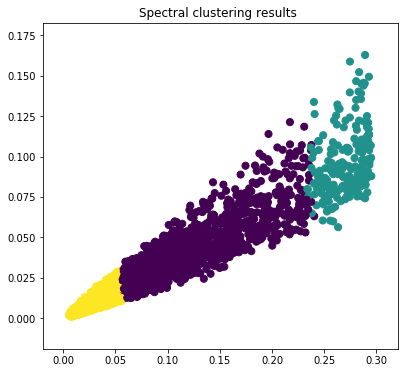

In [44]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.title(f'Spectral clustering results ')
plt.scatter(X[:, 0], X[:, 1], s=50, c = y_pred);

## DBScan

In [45]:
# Compute DBSCAN
start_time = time.time()

print('working...')

db = DBSCAN(eps= .1, min_samples= 4).fit(X)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(labels)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)


print("--- %s seconds ---" % round(time.time() - start_time, 2))

#print("Silhouette Coefficient: {0.3f}".format(metrics.silhouette_score(X, labels)))

working...
[0 0 0 ... 0 0 0]
Estimated number of clusters: 1
Estimated number of noise points: 0
--- 6.83 seconds ---


['y', 'b', 'r', 'g', 'c', 'm', 'w']


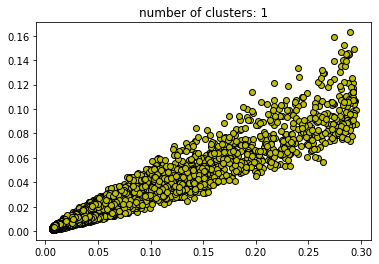

In [46]:
unique_labels = set(labels) 
colors = ['y', 'b', 'r', 'g', 'c', 'm', 'w'] 
print(colors) 
for k, col in zip(unique_labels, colors): 
    if k == -1: 
        # Black used for noise. 
        col = 'k'
  
    class_member_mask = (labels == k) 
  
    xy = X[class_member_mask & core_samples_mask] 
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, 
                                      markeredgecolor='k',  
                                      markersize=6) 
  
    xy = X[class_member_mask & ~core_samples_mask] 
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, 
                                      markeredgecolor='k', 
                                      markersize=6) 
  
plt.title('number of clusters: %d' %n_clusters_) 
plt.show() 

## Affinity Propogation

In [47]:
from sklearn.cluster import AffinityPropagation

In [ ]:
start_time = time.time()

print('working...')

af = AffinityPropagation(preference=-50).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

print("--- %s seconds ---" % round(time.time() - start_time, 2))

working...
